In [202]:
import h5py
from sklearn import metrics
import numpy as np
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
import xgboost
from xgboost.sklearn import XGBClassifier
import argparse, sys, os, errno
import logging
import json
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

In [203]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [204]:
#logistic naivebayesian randomforest knn svc gpr

In [205]:
cd /Share/home/chenxupeng/projects/pr/2D/

/Share/home/chenxupeng/projects/pr/2D


In [33]:
#tensor 形式的  要做数据预处理吗？

In [36]:
a = preprocessing.normalize(neg[0])

In [56]:
'''
test_index = {}
train_index = {}
a = np.arange(3900)
np.random.shuffle(a)
for i in range(10):
    test_index[i] = a[390*i:390*(i+1)]
    train_index[i] = np.setdiff1d(a,test_index[i])
test_index =np.array([val for (key,val) in test_index.iteritems()])
train_index =np.array([val for (key,val) in train_index.iteritems()])
with h5py.File('train_index') as f:
    f.create_dataset('train_index',data =train_index)
with h5py.File('test_index') as f:
    f.create_dataset('test_index',data =test_index)
'''

In [206]:
with h5py.File('2D/image_nega') as f:
    neg = f['image'][:,:,:]
with h5py.File('2D/image_posi') as f:
    pos = f['image'][:,:,:]
with h5py.File('2D/train_index') as f:
    train_index = f['train_index'][:,:]
with h5py.File('2D/test_index') as f:
    test_index = f['test_index'][:,:]
image =np.concatenate((pos,neg))
train_image = {}
test_image ={}
for i in range(10):
    train_image[i] = image[train_index[i]]
    test_image[i] = image[test_index[i]]
y = np.concatenate((np.repeat(1,1950),np.repeat(0,1950)))
train_label = {}
test_label ={}
for i in range(10):
    train_label[i] = y[train_index[i]]
    test_label[i] = y[test_index[i]]
for i in range(10):
    train_image[i] = preprocessing.normalize(train_image[i].reshape(3510,-1))
    test_image[i] = preprocessing.normalize(test_image[i].reshape(390,-1))

IOError: Unable to create file (Unable to open file: name = '2d/image_nega', errno = 2, error message = 'no such file or directory', flags = 15, o_flags = c2)

(3510, 1600)

In [72]:
def create_model(classifier,X_train,y_train,class_weight='balanced'):
    elif classifier == 'SVMLinear':
        model =  LinearSVC( class_weight=class_weight)
        model.fit(X_train, y_train)
        return model
    elif classifier == 'LogRegL1':
        return LogisticRegression(penalty='l1', class_weight=class_weight)
        model.fit(X_train, y_train)
        return model
    elif classifier == 'LogRegL2':
        model =  LogisticRegression(penalty='l2', class_weight=class_weight)
        model.fit(X_train, y_train)
        return model
    elif classifier == 'RandomForest':
        model = RandomForestClassifier( class_weight=class_weight)
        model.fit(X_train, y_train)
        return model
    elif classifier == 'MultinomialNB':
        model =  MultinomialNB()
        model.fit(X_train, y_train)
        return model
    elif classifier == 'GaussianNB':
        model =  GaussianNB()
        model.fit(X_train, y_train)
        return model
    elif classifier == 'XGB':
        model =  XGBClassifier()
        model.fit(X_train, y_train)
        return model
    elif classifier == 'KNN':
        model =  KNeighborsClassifier()
        model.fit(X_train, y_train)
        return model
    elif classifier == 'GPR':
        model = GaussianProcessClassifier()
        model.fit(X_train, y_train)
        return model
    else:
        raise ValueError('Unknown classifier: %s'%classifier)


def evaluate_model(classifier, X_train,y_train,X_test, y_test, eval_metric=None,
                   hyper_params=None):
    model = create_model(classifier,X_train,y_train,class_weight='balanced')
    y_pred = model.predict(X_test)
    result = {}
    # calculate AUC (call predict_proba)
    scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
    result['AUC'] = metrics.auc(fpr, tpr).tolist()
    # calculate weighted accuracy (call score)
    classes, counts = np.unique(y_test, return_counts=True)
    weights = 1.0/counts.astype('float')
    sample_weight = np.empty(len(y_test))
    for c, w in zip(classes, weights):
        sample_weight[y_test == c] = w
    score = metrics.accuracy_score(y_test, y_pred, sample_weight=sample_weight)
    score_ = metrics.accuracy_score(y_test, y_pred, sample_weight=None)
# score = model.score(X_test, y_test, sample_weight=sample_weight)
    result['PredictedLabels'] = y_pred.tolist()
    result['TrueLabels'] = y_test.tolist()
    result['Weighted_Accuracy'] = score.tolist()
    result['Accuracy'] = score_.tolist()
#  result['Performance'] = result[eval_metric]
    if classifier == 'RandomForest':
        result['feature_weight'] = model.feature_importances_.tolist()
    elif classifier == 'GaussianNB':
        result['feature_sigma'] = model.sigma_.tolist()
        result['feature_theta'] = model.theta_.tolist()
    elif classifier == 'LogRegL2':
        result['feature_weight'] = model.coef_.tolist()
    elif classifier == ' SVMLinear':
        result['feature_weight'] = model.coef_.tolist()    
    elif classifier == 'XGB':
        result['feature_weight'] = model.feature_importances_.tolist()
    else:
        raise ValueError('Unknown classifier: %s'%classifier)
    return result

In [ ]:
#flatten image

In [84]:
classification_model = []

(390, 40, 40)

In [116]:
model_name = ['LogRegL2','RandomForest','GaussianNB','XGB','KNN','GPR','SVMLinear']

In [94]:
import os
for i in range(7):
    os.mkdir('/Share/home/chenxupeng/projects/pr/2D/'+model_name[i])

In [97]:
import json

In [145]:
results = {}
for i in range(7):
    results[i] ={}
    for k in range(10):
        path = model_name[i]+'/'+str(k)
        with open(path) as file:
            results[i][k] = json.loads(file.read())

In [166]:
accuracy = np.array([])
AUC = np.array([])
for i in range(7):
    for k in range(10):
        accuracy =  np.append(accuracy,results[i][k]['Accuracy'])
        AUC =  np.append(AUC,results[i][k]['AUC'])

In [167]:
model_accuracy= np.sum(accuracy.reshape(-1,10),axis =1)/10.0
model_AUC= np.sum(AUC.reshape(-1,10),axis =1)/10.0

In [168]:
model_accuracy

array([ 0.30153846,  0.05512821,  0.43564103,  0.05461538,  0.12871795,
        0.27      ,  0.19769231])

In [169]:
model_AUC

array([ 0.22452009,  0.01067822,  0.39848254,  0.0144494 ,  0.12416766,
        0.18428953,  0.11388239])

In [170]:
#分析一下朴素贝叶斯

In [172]:
sigma = np.array([])
theta= np.array([])
for k in range(10):
    sigma =  np.append(sigma,results[2][k]['feature_sigma'])
    theta=  np.append(theta,results[2][k]['feature_theta'])

In [174]:
sigma.shape

(32000,)

In [175]:
theta.shape

(32000,)

In [176]:
#分析一下log

In [178]:
weight = np.array([])
for k in range(10):
    weight =  np.append(weight,results[0][k]['feature_weight'])

In [180]:
weight.shape

(16000,)

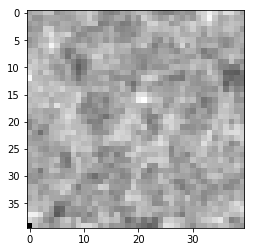

In [183]:
imshow(weight[:1600].reshape(40,40),cmap = cm.binary)

In [184]:
#普通机器学习模型总体效果很差，因为完全忽视了图像特征，还需要压平到一维，可以考虑用CNN试一试！

In [ ]:
#reshape and normalize？还是归一化？

In [217]:
train_image = {}
test_image = {}
with h5py.File('normalized_tensor') as f:
    for i in range(10):
        train_image[i] = f['train_image'+str(i)][:,:,:]
        test_image[i] = f['test_image'+str(i)][:,:,:]

In [219]:
'''
for i in range(10):
    train_image[i] = train_image[i].reshape(train_image[i].shape[0],40,40)
    test_image[i] = test_image[i].reshape(test_image[i].shape[0],40,40)
for i in range(10):
    for j in range(train_image[i].shape[0]):
        train_image[i][j] = preprocessing.normalize(train_image[i][j])
    for k in range(test_image[i].shape[0]):
        test_image[i][k] = preprocessing.normalize(test_image[i][k])
with h5py.File('normalized_tensor') as f:
    for i in range(10):
        f.create_dataset('train_image'+str(i),data = train_image[i])
        f.create_dataset('test_image'+str(i),data = test_image[i])
'''

"\nfor i in range(10):\n    train_image[i] = train_image[i].reshape(train_image[i].shape[0],40,40)\n    test_image[i] = test_image[i].reshape(test_image[i].shape[0],40,40)\nfor i in range(10):\n    for j in range(train_image[i].shape[0]):\n        train_image[i][j] = preprocessing.normalize(train_image[i][j])\n    for k in range(test_image[i].shape[0]):\n        test_image[i][k] = preprocessing.normalize(test_image[i][k])\nwith h5py.File('normalized_tensor') as f:\n    for i in range(10):\n        f.create_dataset('train_image'+str(i),data = train_image[i])\n        f.create_dataset('test_image'+str(i),data = test_image[i])\n"

In [220]:
import keras

In [221]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 2
epochs = 12

# input image dimensions
img_rows, img_cols = 40, 40

# the data, shuffled and split between train and test sets
x_train = train_image[0]
y_train = train_label[0]
x_test =  test_image[0]
y_test =  test_label[0]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (3510, 40, 40, 1)
3510 train samples
390 test samples
Train on 3510 samples, validate on 390 samples
Epoch 1/12


ResourceExhaustedError: OOM when allocating tensor with shape[351000,4096]
	 [[Node: dense_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=729861, _device="/job:localhost/replica:0/task:0/cpu:0"](dense_1/random_uniform/shape)]]

Caused by op u'dense_1/random_uniform/RandomUniform', defined at:
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-192-79e0aea1d8d7>", line 34, in <module>
    model.add(Dense(4096))
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/keras/models.py", line 469, in add
    output_tensor = layer(self.outputs[0])
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 569, in __call__
    self.build(input_shapes[0])
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/keras/layers/core.py", line 825, in build
    constraint=self.kernel_constraint)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/keras/initializers.py", line 208, in __call__
    dtype=dtype, seed=self.seed)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 3536, in random_uniform
    dtype=dtype, seed=seed)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/random_ops.py", line 236, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_random_ops.py", line 249, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Share/home/chenxupeng/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[351000,4096]
	 [[Node: dense_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=729861, _device="/job:localhost/replica:0/task:0/cpu:0"](dense_1/random_uniform/shape)]]


In [ ]:
#mini batch  batch normalization？